# Classifying Salaries of Data-Related Jobs

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import datetime
import time
import random
from tqdm import tqdm
import csv
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [4]:
def extract_location_from_result(result):
    try:
        j_location = result.find('div', attrs={'class':'companyLocation'}).text.strip()
    except:
        j_location = np.nan
    return j_location

def extract_company_from_result(result):
    try:
        j_company = result.find('span', attrs={'class':'companyName'}).text.strip()
    except:
        j_company = np.nan
    return j_company

def extract_title_from_result(result):
    try:
        j_title = result.find('h2', attrs={'class':'jobTitle jobTitle-color-purple'}).text.strip()
    except:
        j_title = np.nan
    return j_title

def extract_salary_from_result(result):
    try:
        j_salary = result.find('div', attrs={'class':'metadata salary-snippet-container'}).text.strip()
    except:
        j_salary = np.nan
    return j_salary

In [5]:
print(extract_location_from_result(soup))
print(extract_company_from_result(soup))
print(extract_title_from_result(soup))
print(extract_salary_from_result(soup))

New York, NY
Turner & Townsend
Data Scientist, Game Analytics & Strategy
$100,550 a year


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

In [6]:
url_template = 'https://uk.indeed.com/jobs?q={}&l={}&start={}'
max_results_per_city = 1 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

cities = ['London', 'Birmingham']

roles = ['Data+Scientist','Data+Engineer']

results = []

headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
#headers here has been used on/off to try to help scrape and avoid constant captcha

for city in tqdm(cities):
    for role in roles:
        for start in range(0, max_results_per_city, 10):
            # Grab the results from the request (as above)
            r = requests.get(url_template.format(role, city, start), headers=headers)
            soup = BeautifulSoup(r.text, 'html.parser')
            # Append to the full set of results
            results.append(soup)
            # sleep function used to slow down the scrape and avoid getting blocked from the page
            time.sleep(random.randint(3,7))
            
    # Outputting raw data for each city as csv
    now = (datetime.datetime.now().strftime('%d%B_%I%M%p'))
    filepathraw = f'/Users/garethharper/Desktop/GA_P2/DSI21-lessons/projects/project-4/raw/{now}.csv'
    with open(filepathraw,'w',newline='') as f:
        wr = csv.writer(f)
        wr.writerows(results)
    pass

100%|██████████| 2/2 [00:27<00:00, 13.65s/it]


### Full list ok UK cities scraped, and roles

In [7]:
# cities = ['London', 'Birmingham', 'Glasgow', 'Liverpool', 'Bristol', 
#           'Manchester', 'Sheffield', 'Leeds', 'Edinburgh', 'Leicester', 
#           'Coventry', 'Bradford', 'Cardiff', 'Belfast', 'Nottingham',
#           'Kingston', 'Newcastle', 'Derby', 'Portsmouth', YOUR_CITY]

# roles = ['Junior+Data+Scientist','Junior+Data+Engineer',
#          'Junior+Data+Consultant','Junior+Data+Analyst']

In [8]:
jobs_indeed = pd.DataFrame(columns=['location','company','job_title','salary'])

for result in tqdm(results):
    for item in result.find_all('div', attrs={'class':'job_seen_beacon'}):
        job_data = {'location': extract_location_from_result(item),
                     'company': extract_company_from_result(item),
                     'job_title': extract_title_from_result(item),
                     'salary': extract_salary_from_result(item)}
        jobs_indeed = jobs_indeed.append(job_data, ignore_index=True)
        
        # Outputting df formatted data to csv
        filepathdf = f'/Users/garethharper/Desktop/GA_P2/DSI21-lessons/projects/project-4/df/{now}.csv'
        jobs_indeed.to_csv(filepathdf, index=False, header=['location','company','job_title','salary'])

100%|██████████| 4/4 [00:00<00:00, 13.12it/s]


In [9]:
jobs_indeed.head()

,location,company,job_title,salary
0,Temporarily Remote in London,Pythia Sports,Data Scientist (Football),NaN
1,Temporarily Remote in London,Pythia Sports,Data Scientist (Cricket),NaN
2,Remote in London,Satalia,NaN,NaN
3,Remote in London,Simply Business,NaN,"£60,000 - £75,000 a year"
4,Hybrid remote in London,Lightricks,NaN,"£80,000 - £100,000 a year"


In [10]:
jobs_indeed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   49 non-null     object
 1   company    49 non-null     object
 2   job_title  31 non-null     object
 3   salary     13 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


### Load in the the data of scraped salaries

In [11]:
path = r'/Users/garethharper/Desktop/GA_P2/DSI21-lessons/projects/project-4/df'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None)
    li.append(df)

df_jobs = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_jobs.head()

,location,company,job_title,salary
0,London SW1V 1PZ•Temporarily Remote,Pythia Sports,NaN,NaN
1,London•Remote,Simply Business,NaN,"£60,000 - £75,000 a year"
2,London,ByteDance,Machine Learning Engineer - Recommendation,"£33,894 - £92,797 a year"
3,London•Remote,Exposed Solutions Limited,NaN,NaN
4,London,The Commonwealth,NaN,NaN


In [13]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59459 entries, 0 to 59458
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   59459 non-null  object
 1   company    59388 non-null  object
 2   job_title  48351 non-null  object
 3   salary     23716 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [14]:
df_jobs.isnull().sum()

location         0
company         71
job_title    11108
salary       35743
dtype: int64

In [15]:
# remove all rows with no entries
df_jobs = df_jobs.dropna()

In [16]:
# only consider annual salaries (i.e. not hourly, daily, weekly or monthly)

# hour-long jobs
print('Hour jobs:', df_jobs[df_jobs.salary.str.contains('hour')].shape)
# day-long jobs
print('Day jobs:', df_jobs[df_jobs.salary.str.contains('day')].shape)
# week-long jobs
print('Week jobs:', df_jobs[df_jobs.salary.str.contains('week')].shape)
# month-long jobs
print('Month jobs:', df_jobs[df_jobs.salary.str.contains('month')].shape)
# year-long jobs
print('Year jobs:', df_jobs[df_jobs.salary.str.contains('year')].shape)

# now filtering for only those containing annual salary
df_jobs = df_jobs[df_jobs.salary.str.contains('year')]

Hour jobs: (703, 4)
Day jobs: (649, 4)
Week jobs: (25, 4)
Month jobs: (8, 4)
Year jobs: (15806, 4)


In [17]:
# remove duplicate entries
df_jobs.drop_duplicates(inplace=True)

In [18]:
df_jobs.shape

(2254, 4)

In [19]:
# some locations may be masking duplicates if the same job posting was pulled
# with a slightly different location.
# Therefore I will drop duplicates on all columns except location.
df_jobs.drop_duplicates(subset=['company','job_title','salary'], inplace=True)

In [20]:
df_jobs.shape
# this value is slightly less than the previous one so my hypothesis was correct

(2145, 4)

#### Function takes a salary string and converts it to a number, averaging a salary range if necessary.

In [21]:
def string_to_int(x):
    """Converts salary string to an integer, and averages if salary is a range"""
    # remove special characters:
    x = re.sub('[£,.a-zA-Z\s]','', x)
    # return value or average value
    try:
        lower, upper = x.split("-")
        x = (int(lower) + int(upper))/2
    except:
        x = x
    return x

In [22]:
df_jobs['salary'] = df_jobs.salary.apply(string_to_int)

In [23]:
df_jobs.head()

,location,company,job_title,salary
2,London,ByteDance,Machine Learning Engineer - Recommendation,63345.5
5,London SE1 0AT,Fable Data,Data Scientist,55000
18,London,Karshare,Business Intelligence Engineer,45000
19,London,Graduate Recruitment Bureau,Graduate Technical Analyst and Support Engineer,26000
35,Birmingham,Openreach,Data Scientist,65000


In [24]:
df_jobs.isnull().sum()

location     0
company      0
job_title    0
salary       0
dtype: int64

In [25]:
# check salary dtype is int
df_jobs['salary'] = df_jobs['salary'].astype(int)

df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 2 to 59021
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   2145 non-null   object
 1   company    2145 non-null   object
 2   job_title  2145 non-null   object
 3   salary     2145 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 83.8+ KB


### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In [26]:
median_salary = df_jobs['salary'].median()
df_jobs['high_salary'] = [1 if v > median_salary else 0 for v in df_jobs['salary']]

#### Thought experiment: What is the baseline accuracy for this model?

The median values implies half the values are above the median and half the values are below the median (i.e. 50% above and 50% below).

There is an equal chance the salary is either high or low.

The baseline accuracy is therefore 50%. 

In [27]:
# code would be something like this
df_jobs.high_salary.value_counts(normalize=True)

0    0.500233
1    0.499767
Name: high_salary, dtype: float64

Before proceeding let me investigate my data further:

In [28]:
df_jobs.describe()

,salary,high_salary
count,2145.000000,2145.000000
mean,40070.171096,0.499767
std,17451.532814,0.500117
min,7826.000000,0.000000
25%,27500.000000,0.000000
50%,36016.000000,0.000000
75%,50000.000000,1.000000
max,121830.000000,1.000000


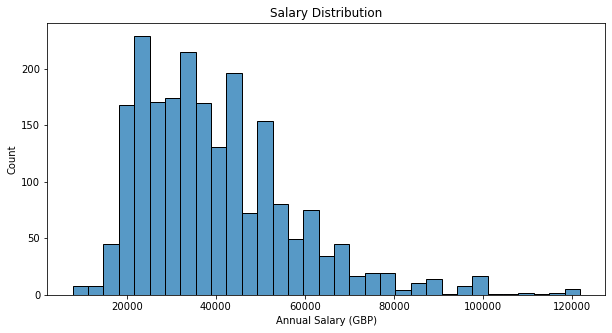

In [29]:
# Salary distribution plot
plt.figure(figsize=[10,5])
sns.histplot(df_jobs['salary'])

plt.title('Salary Distribution')
plt.xlabel('Annual Salary (GBP)')
plt.ylabel('Count')

plt.savefig("images/01 Salary Distribution Histogram.png", bbox_inches="tight")

In [30]:
# discuss graph
median_salary

36016.0

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

##### 1. Start by ONLY using the location as a feature.

In [31]:
# First let me see how many unique locations I have:
df_jobs.location.unique()

array(['London', 'London SE1 0AT', 'Birmingham', 'Birmingham B2',
       'Stafford', 'Worcester•Remote', 'Remote in London',
       'London+5 locations', 'London•Remote', 'London•Temporarily Remote',
       'London WC2H•Remote', 'London W1K', 'London W1B 5AN',
       'London SW1Y•Temporarily Remote', 'London EC4Y',
       'London+1 location', 'London SW19 4JS', 'London N8 8PL•Remote',
       'London E1 4DG', 'London W2 6LA', 'London EC2A 4EG•Remote',
       'London EC1V', 'London SE1 3LE•Remote', 'London EC4R',
       'London EC1V 9BJ', 'London EC4V 4EG',
       'London SW9 6DE•Temporarily Remote', 'London SE1 4YB',
       'London E14 5RE•Temporarily Remote', 'London EC3R',
       'London SE1 7QP•Temporarily Remote', 'London SW1Y 6HD',
       'London E14', 'London SE1 6LH', 'Croydon CR9', 'Victoria',
       'North London', 'London SW1E 5NN•Remote', 'London WC2H',
       'London EC3V 9DU', 'Henley in Arden', 'Leamington Spa',
       'Atherstone CV9 2SQ', 'Warwick CV34 6DA', 'Coventry+1 

In [32]:
df_jobs.location.nunique()

762

In [33]:
cities = ['London', 'Birmingham', 'Glasgow', 'Liverpool', 'Bristol', 
          'Manchester', 'Sheffield', 'Leeds', 'Edinburgh', 'Leicester', 
          'Coventry', 'Bradford', 'Cardiff', 'Belfast', 'Nottingham',
          'Kingston', 'Newcastle', 'Derby', 'Portsmouth', 'Southampton']

In [34]:
# cities

In [35]:
len(cities)

20

In [36]:
df_jobs.head()

,location,company,job_title,salary,high_salary
2,London,ByteDance,Machine Learning Engineer - Recommendation,63345,1
5,London SE1 0AT,Fable Data,Data Scientist,55000,1
18,London,Karshare,Business Intelligence Engineer,45000,1
19,London,Graduate Recruitment Bureau,Graduate Technical Analyst and Support Engineer,26000,0
35,Birmingham,Openreach,Data Scientist,65000,1


So I have many more unique locations than those cities I originally requested. I will clean the locations based on my original "cities" list:

In [37]:
pat = r'\b(?:{})\b'.format('|'.join(cities))
df_jobs['city'] = df_jobs['location'].str.findall('('+ pat +')').str.join('')

In [38]:
df_jobs.head(10)

,location,company,job_title,salary,high_salary,city
2,London,ByteDance,Machine Learning Engineer - Recommendation,63345,1,London
5,London SE1 0AT,Fable Data,Data Scientist,55000,1,London
18,London,Karshare,Business Intelligence Engineer,45000,1,London
19,London,Graduate Recruitment Bureau,Graduate Technical Analyst and Support Engineer,26000,0,London
35,Birmingham,Openreach,Data Scientist,65000,1,Birmingham
36,Birmingham B2,Axa,Data Scientist,50000,1,Birmingham
47,Stafford,Codeweavers,Lead Analytics Engineer,60000,1,
48,Worcester•Remote,Searchability,BI Developer / Automation Engineer,60000,1,
57,London,air-recruitment,Data Scientist - Global & Social Issues,60000,1,London
66,Remote in London,Data Idols,Analytics Engineer,70000,1,London


In [39]:
df_jobs.city.unique()

array(['London', 'Birmingham', '', 'Coventry', 'Glasgow', 'Liverpool',
       'Manchester', 'Bristol', 'Sheffield', 'Bradford', 'Leeds',
       'Edinburgh', 'Derby', 'Nottingham', 'Leicester', 'Cardiff',
       'Belfast', 'Newcastle', 'Portsmouth', 'Southampton', 'Kingston'],
      dtype=object)

In [40]:
df_jobs.city.nunique()

21

In [41]:
df_jobs.city.value_counts()

               791
London         352
Manchester     137
Bristol        135
Leeds          120
Birmingham     109
Glasgow         63
Edinburgh       59
Nottingham      51
Newcastle       42
Cardiff         41
Sheffield       40
Liverpool       36
Coventry        35
Leicester       29
Belfast         29
Southampton     28
Bradford        16
Portsmouth      15
Derby           14
Kingston         3
Name: city, dtype: int64

In [42]:
df_jobs = df_jobs[df_jobs.city != '']

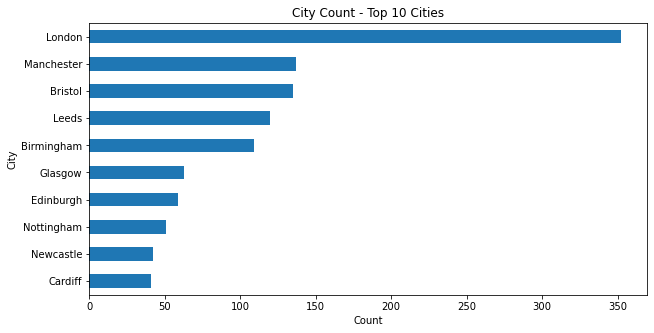

In [43]:
# Visualize city count (top 10 cities)

df_jobs.city.value_counts().head(10).sort_values().plot(kind="barh", figsize=(10,5))
plt.title("City Count - Top 10 Cities")
plt.xlabel("Count")
plt.ylabel("City")

plt.savefig("images/02 City Count.png", bbox_inches="tight")

In [44]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354 entries, 2 to 57900
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   location     1354 non-null   object
 1   company      1354 non-null   object
 2   job_title    1354 non-null   object
 3   salary       1354 non-null   int64 
 4   high_salary  1354 non-null   int64 
 5   city         1354 non-null   object
dtypes: int64(2), object(4)
memory usage: 74.0+ KB


In [45]:
df_jobs.head()

,location,company,job_title,salary,high_salary,city
2,London,ByteDance,Machine Learning Engineer - Recommendation,63345,1,London
5,London SE1 0AT,Fable Data,Data Scientist,55000,1,London
18,London,Karshare,Business Intelligence Engineer,45000,1,London
19,London,Graduate Recruitment Bureau,Graduate Technical Analyst and Support Engineer,26000,0,London
35,Birmingham,Openreach,Data Scientist,65000,1,Birmingham


##### 2. Use at least two different classifiers you find suitable.

- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.


In [46]:
# target and predictors
X = df_jobs[['city']]
y = df_jobs['high_salary']

In [47]:
# dummify cities
X_dummy = pd.get_dummies(X, drop_first=True)

In [48]:
# get train-test split
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2, random_state=42)

In [49]:
# standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Logistic Regression Model

In [50]:
# create a logistic regression model instance
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# fit and evaluate the data on the whole training set
logreg.fit(X_train, y_train)

# get cross validated scores
scores = cross_val_score(logreg, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", logreg.score(X_train, y_train))
print("Test Score:", logreg.score(X_test, y_test))

Cross-validated training scores: [0.49308756 0.58064516 0.50230415 0.5462963  0.54166667]
Mean cross-validated training score: 0.532799965864482
Training Score: 0.5844875346260388
Test Score: 0.5018450184501845


In [51]:
logreg_coefs = pd.DataFrame({'variable': X_dummy.columns,
                            'coef': logreg.coef_[0],
                            'abs_coef': np.abs(logreg.coef_[0])})

logreg_coefs.sort_values('abs_coef', inplace=True, ascending=False)
logreg_coefs

,variable,coef,abs_coef
12,city_London,0.498506,0.498506
0,city_Birmingham,0.310175,0.310175
13,city_Manchester,0.214948,0.214948
11,city_Liverpool,0.195761,0.195761
2,city_Bristol,0.153341,0.153341
7,city_Glasgow,0.121094,0.121094
17,city_Sheffield,0.107649,0.107649
9,city_Leeds,0.103885,0.103885
6,city_Edinburgh,0.088885,0.088885
10,city_Leicester,0.083095,0.083095


#### Decision Tree Classifier

In [52]:
# create a decision tree classification model instance
from sklearn.tree import DecisionTreeClassifier
dectrec = DecisionTreeClassifier()

# fit and evaluate the data on the whole training set
dectrec.fit(X_train, y_train)

# get cross validated scores
scores = cross_val_score(dectrec, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", dectrec.score(X_train, y_train))
print("Test Score:", dectrec.score(X_test, y_test))

Cross-validated training scores: [0.49308756 0.58064516 0.50230415 0.5462963  0.54166667]
Mean cross-validated training score: 0.532799965864482
Training Score: 0.5844875346260388
Test Score: 0.5018450184501845


In [53]:
pd.DataFrame(list(zip(X_dummy.columns, dectrec.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

,Feature,Importance
12,city_London,0.457622
0,city_Birmingham,0.208913
11,city_Liverpool,0.104058
13,city_Manchester,0.063363
5,city_Derby,0.046810
14,city_Newcastle,0.036601
17,city_Sheffield,0.012136
3,city_Cardiff,0.010195
7,city_Glasgow,0.009659
4,city_Coventry,0.008812


#### Random Forest Classifier

In [54]:
# create a random forest classification model instance
from sklearn.ensemble import RandomForestClassifier
ranforc = RandomForestClassifier()

# fit and evaluate the data on the whole training set
ranforc.fit(X_train, y_train)

# get cross validated scores
scores = cross_val_score(ranforc, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", ranforc.score(X_train, y_train))
print("Test Score:", ranforc.score(X_test, y_test))

Cross-validated training scores: [0.49308756 0.5483871  0.50230415 0.5462963  0.53240741]
Mean cross-validated training score: 0.5244965011094044
Training Score: 0.5844875346260388
Test Score: 0.5055350553505535


In [55]:
pd.DataFrame(list(zip(X_dummy.columns, ranforc.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

,Feature,Importance
12,city_London,0.284529
0,city_Birmingham,0.103735
14,city_Newcastle,0.063569
11,city_Liverpool,0.060908
5,city_Derby,0.059852
9,city_Leeds,0.055077
13,city_Manchester,0.041222
3,city_Cardiff,0.040702
2,city_Bristol,0.035475
18,city_Southampton,0.031036


The models all have approximately the same mean cv score around 0.55. This is marginally better than the baseline score of 0.5. However at this point we are only using a single feature, the location.

#### 3. Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.

Some interesting features that can be extracted from the job title include position and level (grade). 

These are defined below in separate lists.

In [56]:
positions = {'Scientist', 'Analyst', 'Consultant', 'Engineer', 'Architect',
             'Developer', 'Professor'}

In [57]:
def position_finder(x):
    """Extracts position from job_title"""
    """Note: position must be in positions set"""
    df_positions = set(x.split(' '))
    extract_positions = positions.intersection(df_positions)
    return ', '.join(extract_positions)

In [58]:
df_jobs['position'] = df_jobs['job_title'].apply(position_finder)

In [59]:
levels = {'Graduate', 'Postgraduate', 'Entry', 'Junior', 'Senior', 'Associate', 'Manager', 'Lead', 'Principal', 'Specialist'} 

In [60]:
def level_finder(x):
    """Extracts level from job_title"""
    """Note: level must be in levels set"""
    df_levels = set(x.split(' '))
    extract_levels = levels.intersection(df_levels)
    return ', '.join(extract_levels)

In [61]:
df_jobs['level'] = df_jobs['job_title'].apply(level_finder)

In [62]:
df_jobs.head()

,location,company,job_title,salary,high_salary,city,position,level
2,London,ByteDance,Machine Learning Engineer - Recommendation,63345,1,London,Engineer,
5,London SE1 0AT,Fable Data,Data Scientist,55000,1,London,Scientist,
18,London,Karshare,Business Intelligence Engineer,45000,1,London,Engineer,
19,London,Graduate Recruitment Bureau,Graduate Technical Analyst and Support Engineer,26000,0,London,"Engineer, Analyst",Graduate
35,Birmingham,Openreach,Data Scientist,65000,1,Birmingham,Scientist,


In [63]:
df_jobs['position'].value_counts()

Analyst                  435
                         380
Consultant               211
Engineer                 142
Scientist                109
Developer                 52
Professor                  4
Architect                  4
Consultant, Analyst        3
Scientist, Engineer        3
Engineer, Developer        2
Developer, Analyst         2
Engineer, Architect        1
Architect, Consultant      1
Scientist, Analyst         1
Analyst, Consultant        1
Developer, Consultant      1
Scientist, Consultant      1
Engineer, Analyst          1
Name: position, dtype: int64

In [64]:
df_jobs['level'].value_counts()

                         911
Senior                   178
Junior                    65
Manager                   58
Lead                      39
Graduate                  38
Associate                 16
Specialist                12
Principal                  8
Manager, Senior            7
Senior, Associate          5
Junior, Graduate           4
Entry                      3
Postgraduate               2
Specialist, Principal      2
Manager, Junior            2
Junior, Manager            2
Manager, Lead              1
Specialist, Senior         1
Name: level, dtype: int64

#### 4. Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [65]:
# target and predictors
Xn = df_jobs[['city', 'position', 'level']]
yn = df_jobs['high_salary']

In [66]:
# dummify cities
Xn_dummy = pd.get_dummies(Xn, drop_first=True)
# Xn_dummy = Xn_dummy.drop(['position_','level_'], axis=1)

In [67]:
# get train-test split
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn_dummy, yn, test_size=0.2, random_state=42)

In [68]:
# standardize features
Xn_train = scaler.fit_transform(Xn_train)
Xn_test = scaler.transform(Xn_test)

#### Logistic Regression Model

In [69]:
# create a logistic regression model instance
logregn = LogisticRegression(random_state=42)

# fit and evaluate the data on the whole training set
logregn.fit(Xn_train, yn_train)

# get cross validated scores
scores = cross_val_score(logregn, Xn_train, yn_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", logregn.score(Xn_train, yn_train))
print("Test Score:", logregn.score(Xn_test, yn_test))

Cross-validated training scores: [0.6359447  0.70506912 0.64976959 0.68518519 0.68055556]
Mean cross-validated training score: 0.6713048301757979
Training Score: 0.7100646352723915
Test Score: 0.7011070110701108


In [70]:
# tune model using GridSearchCV
from sklearn.model_selection import GridSearchCV

In [71]:
# gridsearch params
logr_params = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': np.logspace(-4, 4, 9)
}

# set the gridsearch
model_logr = LogisticRegression(random_state=42)
logr_gs = GridSearchCV(model_logr, logr_params, cv=5,
                      verbose=1, n_jobs=-2, return_train_score=True)

# use the gridearch model to fit the data
logr_gs.fit(Xn_train, yn_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-2,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, verbose=1)

In [72]:
# assign your best estimator to a variable
logr_best = logr_gs.best_estimator_

# print out the best parameters
print(logr_gs.best_params_)
# print out the best mean cross-validated score
print("Best Mean CV score:", logr_gs.best_score_)
# print out the best testing score
print("Best Test score:", logr_gs.score(Xn_test, yn_test))

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean CV score: 0.6814516129032258
Best Test score: 0.6863468634686347


In [73]:
logregn_coefs = pd.DataFrame({'variable': Xn_dummy.columns,
                            'coef': logr_best.coef_[0],
                            'abs_coef': np.abs(logr_best.coef_[0])})

logregn_coefs.sort_values('abs_coef', inplace=True, ascending=False)
logregn_coefs.head(10)

,variable,coef,abs_coef
39,level_Graduate,-0.561194,0.561194
50,level_Senior,0.416653,0.416653
43,level_Lead,0.388007,0.388007
28,position_Engineer,0.369279,0.369279
40,level_Junior,-0.311670,0.311670
12,city_London,0.310059,0.310059
33,position_Scientist,0.297932,0.297932
0,city_Birmingham,0.201507,0.201507
41,"level_Junior, Graduate",-0.157604,0.157604
49,level_Principal,0.149831,0.149831


#### Decision Tree Classifier

In [74]:
# create a decision tree classification model instance
dectrecn = DecisionTreeClassifier(random_state=42)

# fit and evaluate the data on the whole training set
dectrecn.fit(Xn_train, yn_train)

# get cross validated scores
scores = cross_val_score(dectrecn, Xn_train, yn_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", dectrecn.score(Xn_train, yn_train))
print("Test Score:", dectrecn.score(Xn_test, yn_test))

Cross-validated training scores: [0.640553   0.70967742 0.67281106 0.69444444 0.64814815]
Mean cross-validated training score: 0.6731268134493942
Training Score: 0.7710064635272391
Test Score: 0.6273062730627307


In [75]:
# gridsearch params
dtc_params = {
    'max_depth': [None]+list(range(1, 10)),
    'max_features': ['auto','sqrt','log2'],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20],
    'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]
}

# set the gridsearch
model_dtc = DecisionTreeClassifier(random_state=42)
dtc_gs = GridSearchCV(model_dtc, dtc_params, cv=5,
                      verbose=1, n_jobs=-2, return_train_score=True)

# use the gridearch model to fit the data
dtc_gs.fit(Xn_train, yn_train)

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20]},
             return_train_score=True, verbose=1)

In [76]:
# assign your best estimator to a variable
dtc_best = dtc_gs.best_estimator_

# print out the best parameters
print(dtc_gs.best_params_)
# print out the best mean cross-validated score
print("Best Mean CV score:", dtc_gs.best_score_)
# print out the best testing score
print("Best Test score:", dtc_gs.score(Xn_test, yn_test))

{'ccp_alpha': 0.0001, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 20}
Best Mean CV score: 0.6814601467827274
Best Test score: 0.6199261992619927


In [77]:
pd.DataFrame(list(zip(Xn_dummy.columns, dtc_best.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
50,level_Senior,0.108848
39,level_Graduate,0.087272
33,position_Scientist,0.074919
28,position_Engineer,0.062716
43,level_Lead,0.052191
12,city_London,0.046793
11,city_Liverpool,0.036055
2,city_Bristol,0.035674
0,city_Birmingham,0.035361
40,level_Junior,0.035051


#### Random Forest Classifier

In [78]:
# create a random forest classification model instance
ranforcn = RandomForestClassifier(random_state=42)

# fit and evaluate the data on the whole training set
ranforcn.fit(Xn_train, yn_train)

# get cross validated scores
scores = cross_val_score(ranforcn, Xn_train, yn_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# evaluate data on the train and test set
print("Training Score:", ranforcn.score(Xn_train, yn_train))
print("Test Score:", ranforcn.score(Xn_test, yn_test))

Cross-validated training scores: [0.64976959 0.68202765 0.65898618 0.66203704 0.63888889]
Mean cross-validated training score: 0.6583418672128349
Training Score: 0.7710064635272391
Test Score: 0.6642066420664207


In [79]:
# gridsearch params
rfc_params = {
    'n_estimators': [50, 100],
    'max_depth': [None]+list(range(1, 10)),
    'max_features': ['auto','sqrt','log2'],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25]
}

# set the gridsearch
model_rfc = RandomForestClassifier(random_state=42)
rfc_gs = GridSearchCV(model_rfc, rfc_params, cv=5,
                      verbose=1, n_jobs=-2, return_train_score=True)

# use the gridearch model to fit the data
rfc_gs.fit(Xn_train, yn_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-2,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25],
                         'n_estimators': [50, 100]},
             return_train_score=True, verbose=1)

In [80]:
# assign your best estimator to a variable
rfc_best = rfc_gs.best_estimator_

# print out the best parameters
print(rfc_gs.best_params_)
# print out the best mean cross-validated score
print("Best Mean CV score:", rfc_gs.best_score_)
# print out the best testing score
print("Best Test score:", rfc_gs.score(Xn_test, yn_test))

{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 25, 'n_estimators': 50}
Best Mean CV score: 0.676826250213347
Best Test score: 0.6605166051660517


In [81]:
pd.DataFrame(list(zip(Xn_dummy.columns, rfc_best.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
50,level_Senior,0.119335
39,level_Graduate,0.089287
28,position_Engineer,0.060805
33,position_Scientist,0.060539
43,level_Lead,0.055861
12,city_London,0.052250
19,position_Analyst,0.052000
40,level_Junior,0.048600
23,position_Consultant,0.031270
25,position_Developer,0.028339


The 'location' feature does not seem to be as important as the 'level' and 'position' features I defined. The most important features across all three models were:
- level = Senior/Graduate,
- position = Engineer/Scientist, and
- location = London (Liverpool made it into the top 10 features for the Decision Tree model)

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

My best performing model was my Logistic Regression model. I will use this model moving forward.

In [82]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import scikitplot as skplt

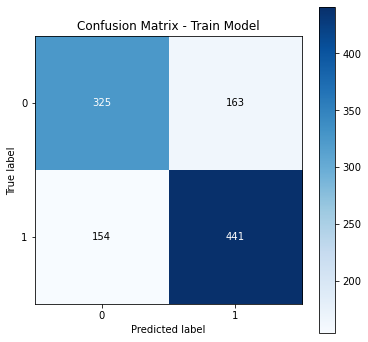

In [83]:
# Confusion matrix

#predictions
predictions_train = logr_best.predict(Xn_train)
predictions_test = logr_best.predict(Xn_test)

# plot Confusion matrix for train predictions
skplt.metrics.plot_confusion_matrix(yn_train, predictions_train, figsize=(6,6))
plt.title("Confusion Matrix - Train Model")

# # plot Confusion matrix for test predictions
# skplt.metrics.plot_confusion_matrix(yn_test, predictions_test, figsize=(6, 6))
# plt.title("Confusion Matrix - Test Model")

plt.savefig("images/04 Confusion Matrix - original.png", bbox_inches="tight")

In [84]:
# Accuracy score

# train score
print("Best Train score:", accuracy_score(yn_train, predictions_train))
# mean cv score
print("Best Mean CV score:", logr_gs.best_score_)
# test score
print("Best Test score:", accuracy_score(yn_test, predictions_test))

Best Train score: 0.7072945521698984
Best Mean CV score: 0.6814516129032258
Best Test score: 0.6863468634686347


In [85]:
# Classification report

# for train model
print("TRAIN MODEL:\n", classification_report(yn_train, predictions_train), "\n")
# for test model
print("TEST MODEL:\n", classification_report(yn_test, predictions_test))

TRAIN MODEL:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67       488
           1       0.73      0.74      0.74       595

    accuracy                           0.71      1083
   macro avg       0.70      0.70      0.70      1083
weighted avg       0.71      0.71      0.71      1083
 

TEST MODEL:
               precision    recall  f1-score   support

           0       0.63      0.69      0.66       118
           1       0.74      0.69      0.71       153

    accuracy                           0.69       271
   macro avg       0.68      0.69      0.68       271
weighted avg       0.69      0.69      0.69       271



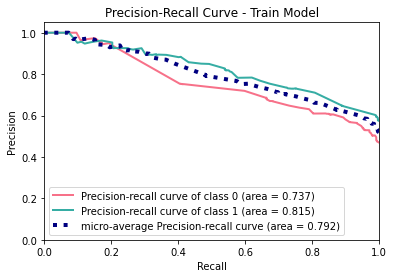

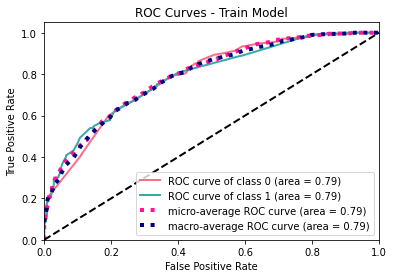

In [86]:
# Precision-recall and ROC curve

# probabilities
probabilities_train = logr_best.predict_proba(Xn_train)
probabilities_test = logr_best.predict_proba(Xn_test)

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(logr_best.classes_)))

# Precision-Recall Curve for train probabilities
skplt.metrics.plot_precision_recall(yn_train, probabilities_train, cmap=cmap)
plt.title("Precision-Recall Curve - Train Model")

# ROC Curves for train probabilities
skplt.metrics.plot_roc(yn_train, probabilities_train, cmap=cmap)
plt.title("ROC Curves - Train Model")

# # Precision-Recall Curve for test probabilities
# skplt.metrics.plot_precision_recall(yn_test, probabilities_test, cmap=cmap)
# plt.title("Precision-Recall Curve - Test Model")

# # ROC Curves for test probabilities
# skplt.metrics.plot_roc(yn_test, probabilities_test, cmap=cmap)
# plt.title("ROC Curves - Test Model")

plt.savefig("images/05 PR-AUROC Curvers - original.png", bbox_inches="tight")

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

#### Increase the threshold for predicting a lower salary job.

Right now the classifier is choosing to label low salary versus high salary based on the 0.5 predicted probability threshold. 


In [87]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(logr_best.predict_proba(Xn_train), 
             columns=['low_salary', 'high_salary'])
Y_pp.head()

,low_salary,high_salary
0,0.312979,0.687021
1,0.179791,0.820209
2,0.363881,0.636119
3,0.614302,0.385698
4,0.336315,0.663685


In [88]:
def predict_at_threshold(x, threshold=0.5):
    if x <= threshold:
        return 1
    else:
        return 0

In [89]:
# Create a new column with predicted labels where the threshold
#  for labeling class is 80% rather than 50%.
Y_pp['pred_class_thresh'] = Y_pp['low_salary'].apply(predict_at_threshold, 
                                                threshold=0.2)

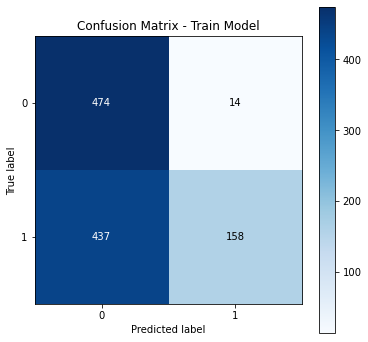

In [90]:
# plot Confusion matrix for train predictions
skplt.metrics.plot_confusion_matrix(yn_train, Y_pp.pred_class_thresh, figsize=(6,6))
plt.title("Confusion Matrix - Train Model")

plt.savefig("images/06 Confusion Matrix - threshold.png", bbox_inches="tight")

In [91]:
# Accuracy score

# train score
print("Train score:", accuracy_score(yn_train, Y_pp.pred_class_thresh))

Train score: 0.5835641735918744


In [92]:
# Classification report

# for train model
print("TRAIN MODEL:\n", classification_report(yn_train, Y_pp.pred_class_thresh))

TRAIN MODEL:
               precision    recall  f1-score   support

           0       0.52      0.97      0.68       488
           1       0.92      0.27      0.41       595

    accuracy                           0.58      1083
   macro avg       0.72      0.62      0.54      1083
weighted avg       0.74      0.58      0.53      1083



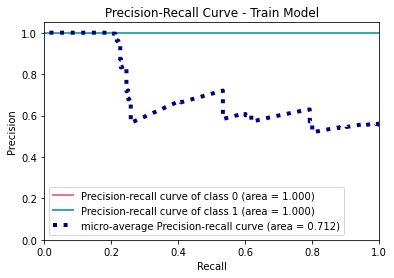

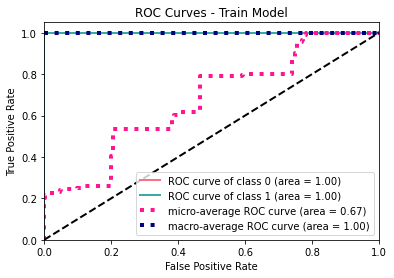

In [93]:
# Precision-recall and ROC curve

# probabilities
probabilities_train = logr_best.predict_proba(Xn_train)

# Precision-Recall Curve for train probabilities
skplt.metrics.plot_precision_recall(Y_pp['pred_class_thresh'], probabilities_train, cmap=cmap)
plt.title("Precision-Recall Curve - Train Model")

# ROC Curves for train probabilities
skplt.metrics.plot_roc(Y_pp['pred_class_thresh'], probabilities_train, cmap=cmap)
plt.title("ROC Curves - Train Model")

plt.savefig("images/07 PR-AUROC Curvers - threshold.png", bbox_inches="tight")

`Precision = TP / (TP + FP)`

`Recall = TP / (TP + FN)`

The tradeoff with telling a client incorrectly that they would get a lower salary job over telling a client incorrectly that they would get a high salary job, is that the model recall (The ability of the classifier to correctly identify the current class) increases at the expense of the model precision (The ability of the classifier to avoid labeling a class as a member of another class).

If the number of FN values decreases (and the value of FP increases), model recall increases while model precision decreases.